# Deep Learning - Previsão de Séries Temporais com LSTM

## Objetivo
O objetivo deste notebook é construir, treinar e avaliar um modelo de Redes Neurais Recorrentes do tipo **LSTM (_Long Short-Term Memory_)** para prever os preços de fechamento das ações da **Microsoft (MSFT)**. Diferente dos modelos estatísticos lineares (como o ARIMA), buscaremos capturar padrões complexos e dependências de longo prazo na série temporal.

## Ativo de Estudo
* **Ticker:** MSFT (Microsoft Corporation)
* **Fonte:** Dataset Big Tech Giants / Yahoo Finance
* **Métrica Principal:** Preço de Fechamento (Close)

## Pipeline de Desenvolvimento
1. **Preparação de Dados:** Seleção do ativo e limpeza.
2. **Normalização:** Escalonamento dos dados entre 0 e 1 (MinMaxScaler).
3. **Criação da Janela de Memória:** Estruturação dos dados em sequências temporais (Lookback Period).
4. **Arquitetura da Rede:** Definição das camadas LSTM, Dropout e Dense.
5. **Treinamento e Validação:** Monitoramento da perda (Loss) e ajuste de hiperparâmetros.
6. **Avaliação e Previsão:** Comparação entre valores reais e previstos com métricas de erro (RMSE/MAE).

### 1. Importação e Pré-processamento
Nesta etapa, filtramos os dados históricos da Microsoft e aplicamos a normalização Min-Max. O escalonamento é vital para redes neurais, pois acelera a convergência do gradiente e evita que valores de preços altos (ex: $300) causem instabilidade numérica nos pesos da rede.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('../data/big_tech_stock_prices.csv')
df.head()

,stock_symbol,date,open,high,low,close,adj_close,volume
0,AAPL,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515213,493729600
1,AAPL,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526476,601904800
2,AAPL,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422664,552160000
3,AAPL,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410790,477131200
4,AAPL,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453412,447610800


In [3]:
# Selecionando dados da Microsoft
df_msft = df[df['stock_symbol'] == 'MSFT'].copy()
df_msft.head()

,stock_symbol,date,open,high,low,close,adj_close,volume
28856,MSFT,2010-01-04,30.620001,31.100000,30.590000,30.950001,23.683071,38409100
28857,MSFT,2010-01-05,30.850000,31.100000,30.639999,30.959999,23.690725,49749600
28858,MSFT,2010-01-06,30.879999,31.080000,30.520000,30.770000,23.545338,58182400
28859,MSFT,2010-01-07,30.629999,30.700001,30.190001,30.450001,23.300467,50559700
28860,MSFT,2010-01-08,30.280001,30.879999,30.240000,30.660000,23.461161,51197400


In [4]:
# Isolando a variável alvo (preço de fechamento)
target = df_msft['close'].values.reshape(-1,1)
target.shape

(3271, 1)

In [5]:
# Aplicando o MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
target_scaled = scaler.fit_transform(target)
target_scaled.shape

(3271, 1)

### 2. Estruturação dos Dados (Janelas Temporais)
O LSTM precisa receber os dados em um formato de "supervisionado". Criaremos janelas de **60 dias (_lookback_)**:
* **X (Inputs):** Sequências contendo os preços dos últimos 60 dias.
* **y (Target):** O preço do dia seguinte (61º dia).

Este processo transforma a série única em um conjunto de amostras que a rede usará para aprender a relação entre o passado recente e o futuro imediato.

In [6]:
# Definindo o tamanho da janela
window_size = 60

X = []
y = []

for i in range(window_size, len(target_scaled)):
    X.append(target_scaled[i-window_size:i, 0])
    y.append(target_scaled[i,0])

# Convertendo para arrays numpy
X, y = np.array(X), np.array(y)

print("Formato de X:", X.shape)

Formato de X: (3211, 60)


In [7]:
# Reshape de X para (samples, time_steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
print("Novo formato de X:", X.shape)

Novo formato de X: (3211, 60, 1)


In [8]:
# Separando em treino e teste

train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Tamanho de X_train:", len(X_train))
print("Tamanho de X_test:", len(X_test))

Tamanho de X_train: 2568
Tamanho de X_test: 643


### 3. Construção e Treinamento do Modelo LSTM
Nesta etapa, definimos a arquitetura da rede neural. Utilizaremos uma **Stacked LSTM** com as seguintes características:
* **Camadas LSTM:** Responsáveis por aprender as dependências temporais.
* **Dropout:** Camadas de regularização que "desligam" neurônios aleatoriamente para evitar o *_overfitting_*.
* **Dense Layer:** Uma camada de saída que consolida o aprendizado em um único valor (o preço previsto).
* **Optimizer (Adam):** Algoritmo de otimização eficiente para ajustar os pesos da rede.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

# Construindo o modelo LSTM
model = Sequential()

# Primeira camada LSTM com Dropout
model.add(Input(shape=(X_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Segunda camada LSTM com Dropout
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Camada de saída
model.add(Dense(units=1))

# Compilação
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Definindo o early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Treinando o modelo
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0022 - val_loss: 9.7195e-04
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.9849e-04 - val_loss: 0.0012
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.6397e-04 - val_loss: 0.0012
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.1437e-04 - val_loss: 9.1944e-04
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.9065e-04 - val_loss: 8.8629e-04
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.9893e-04 - val_loss: 0.0013
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2.6628e-04 - val_loss: 0.0013
Epoch 8/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.7773e-04 - val_loss: 0.0015
Epoch 9/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.7434e-04 - val_loss: 9.7076e-04
Epoch 10/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.2196e-04 - val_loss: 0.0012
Epoch 11/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.4827e-04 - val_loss: 9.1

## 5. Avaliação de Desempenho e Previsões
Nesta etapa, utilizamos o modelo treinado para prever os preços no conjunto de teste. 
Como os dados estão normalizados, realizaremos a **Inversão da Escala** para retornar os valores aos preços originais em dólares. 
A métrica principal de avaliação será o **RMSE (Root Mean Squared Error)**, que nos indica a magnitude média do erro das previsões.

In [11]:
from sklearn.metrics import mean_squared_error

# Fazendo previsões
y_pred_scaled = model.predict(X_test)

# Invertendo a escala das previsões
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_real = scaler.inverse_transform(y_test.reshape(-1,1))

# Calculando o RMSE
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred))
print(f"RMSE do modelo LSTM: {rmse:.2f} USD")

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
RMSE do modelo LSTM: 7.38 USD


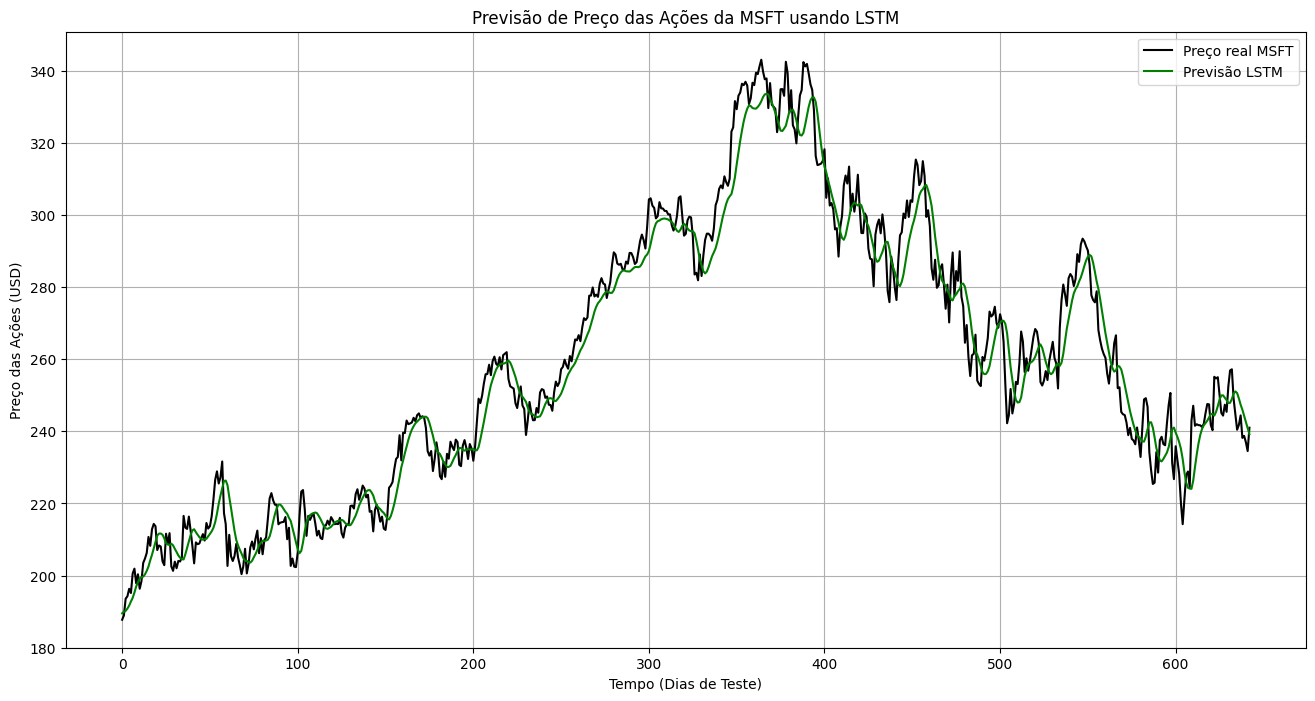

In [ ]:
# Plotando os resultados

plt.figure(figsize=(16,8))
plt.plot(y_test_real, color='black', label='Preço real MSFT')
plt.plot(y_pred, color='green', label='Previsão LSTM')
plt.title('Previsão de Preço das Ações da MSFT usando LSTM')
plt.xlabel('Tempo (Dias de Teste)')
plt.ylabel('Preço das Ações (USD)')
plt.grid()
plt.legend()
plt.show()

### 6. Análise de Resultados e Conclusões

#### Performance do Modelo
* **RMSE (Root Mean Squared Error):** 7.38 USD.
* **Aderência:** O gráfico demonstra que a rede LSTM conseguiu acompanhar as principais tendências de alta e baixa do ativo. 
* **Efeito de Lag (Atraso):** Como esperado em modelos de séries temporais, observa-se um leve atraso nas previsões em momentos de reversão brusca de tendência. Isso ocorre porque o modelo baseia sua decisão nos 60 dias anteriores.

#### Insights Técnicos
1. **Captura de Volatilidade:** O modelo não apenas seguiu a média, mas tentou mapear os picos e vales, o que indica que as camadas de Dropout ajudaram na generalização sem causar um suavização excessiva (underfitting).
2. **Estabilidade:** A convergência da perda durante o treinamento refletiu-se em previsões estáveis no conjunto de teste, sem ruídos aleatórios extremos.

Vamos finalizar o notebook salvando o modelo.

In [14]:
import joblib

# Salvando o modelo treinado e o scaler

model.save('../models/msft_lstm_model_v1.keras')
print("Modelo salvo com sucesso!")

joblib.dump(scaler, '../models/msft_scaler.pkl')
print("Scaler salvo com sucesso!")

Modelo salvo com sucesso!
Scaler salvo com sucesso!


## Fim do notebook.